# `comp-03`: Voxelwise encoding models
This demo introduces forward encoding models—that is, using regularized regression to predict voxelwise activity from an explicit model of the stimulus in left-out data. Here, we use a semantic forward encoding model capturing the meaning of words to predict fMRI activity while participants listen to a spoken narrative (similarly to e.g. [Huth et al., 2016](https://doi.org/10.1038/nature17637)). The words in each TR are assigned a vector (i.e. word embedding) representing their location in a high-dimensional semantic space. For each voxel, we'll fit a model that predicts the time series of brain activity from the semantic vectors assigned to eachtime point.

In [15]:
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
import pandas as pd
import json

The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.


### Naturalistic story-listening dataset
As an example, we'll use fMRI data collected for a single subject listening to a spoken story called "[I Knew You Were Black](https://themoth.org/stories/i-knew-you-were-black)" by Carol Daniel. These data are available as part of the publicly available [Narratives](https://github.com/snastase/narratives) collection ([Nastase et al., 2019](https://openneuro.org/datasets/ds002345)). Here, we'll download a single subject from the server for analysis. If you're working on the server, use `cp` on the command line to create a copy of the following file in your working directory; if you're working locally, use `scp` to download the file to your machine:

`/jukebox/PNI-classes/students/NEU502/2023-NEU502B/brainiak-aperture-data/sub-284_task-black_space-MNI152NLin2009cAsym_res-native_desc-clean_bold.nii.gz`

This dataset has been preprocessed using fMRIPrep with confound regression in AFNI. The functional data have been spatially normalized to a template in MNI space. To reduce computational demands, we compute parcel-wise ISCs using a cortical parcellation containing 400 parcels from [Schaefer and colleages (2018)](https://doi.org/10.1093/cercor/bhx179). Load in the functional data and atlas. Use the parcellation to extract the mean functional time series for each parcel.

In [16]:
# Filenames for intact notthefall data and Schaefer atlas
func_fn = ('sub-284_task-black_space-MNI152NLin2009cAsym_res-native_desc-clean_bold.nii.gz')
atlas_fn = ('Schaefer2018_400Parcels_17Networks_order_FSLMNI152_2.5mm.nii.gz')

# Load in the Schaefer 400-parcel atlas
atlas_nii = nib.load(atlas_fn)
atlas_img = atlas_nii.get_fdata()

# Load in intact functional data and compute parcel means:
func_data = nib.load(func_fn).get_fdata()

func_means = [np.mean(func_data[atlas_img == parcel, :], axis=0)
              for parcel in np.unique(atlas_img)[1:]]
func_parcels = np.column_stack(func_means)

In [17]:
func_parcels.shape

(550, 400)

To orient ourselves a bit, let's try plotting the BOLD time series for an example parcel. Start with parcel `196` in left superior temporal auditory association cortex. After plotting the time series, plot the location of this parcel in the brain using `plot_stat_map`.

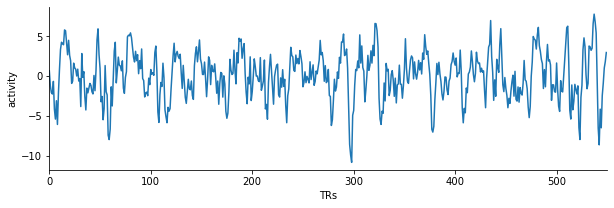

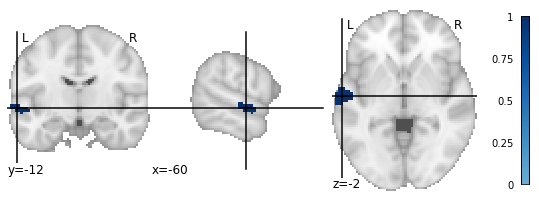

In [18]:
# Plot the time series for an example parcel:
from nilearn.plotting import plot_stat_map

example_parcel = 196
func_parcel = func_parcels[:, example_parcel]

fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(func_parcel)
ax.set(xlabel='TRs', ylabel='activity', xlim=(0, len(func_parcel)))
sns.despine()

# Plot parcel on MNI atlas:
roi_img = np.zeros(atlas_img.shape)
roi_img[atlas_img == example_parcel] = 1
roi_nii = nib.Nifti1Image(roi_img, atlas_nii.affine, atlas_nii.header)
plot_stat_map(roi_nii, cmap='Blues');

### Semantic encoding model
We'll decompose the story stimulus into a series of semantic features based on a simple, widely used representation of word meaning called GloVe ([Pennington et al., 2014](http://dx.doi.org/10.3115/v1/D14-1162])). GloVe represents each word in a 300-dimensional semantic space where words that are nearer in space are more semantically similar based on co-occurrence statistics from a large corpus of text. We start with a time-stamped stimulus transcript. For each TR, we identify which words occurred in that TR, then assign that TR the semantic embeddings associated with each word. For TRs with multiple words, we average the semantic embeddings; for TRs with no words, we use a 300-dimensional vector of zeros; we exclude a small number of stop words. Finally, to account for the hemodynamic lag in fMRI, we create lagged versions of the embeddings.

In [19]:
# Load in time-stamped transcript
transcript_fn = 'black_gentle.csv'
transcript = pd.read_csv(transcript_fn, sep=',')

# Stimulus is roughly 800 seconds long
tr = 1.5
stim_dur = 120
stim_trs = 120 // tr




# Convert transcript to list for simplicity
transcript = transcript.values.tolist()

In [20]:
transcript

[['So', 'so', 0.24, 0.63],
 ['I', 'i', 0.68, 1.26],
 ['was', 'was', 1.96, 2.3],
 ['a', 'a', 2.3, 2.45],
 ['junior', 'junior', 2.46, 3.14],
 ['in', 'in', 3.14, 3.41],
 ['college', 'college', 3.41, 4.2],
 ['when', 'when', 4.79, 5.0200000000000005],
 ['I', 'i', 5.02, 5.09],
 ['got', 'got', 5.09, 5.33],
 ['my', 'my', 5.35, 5.59],
 ['first', 'first', 5.61, 6.34],
 ['paying', 'paying', 7.11, 7.630000000000001],
 ['in', 'in', 7.64, 7.659999999999999],
 ['my', 'my', 8.929999, 9.199999],
 ['field', 'field', 9.21, 9.99],
 ['on', 'on', 10.29, 10.5],
 ['the', 'the', 10.5, 10.62],
 ['radio', 'radio', 10.62, 11.36],
 ['This', 'this', 11.82, 11.97],
 ['is', 'is', 11.969999, 12.089999],
 ['not', 'not', 12.09, 12.32],
 ['an', 'an', 12.32, 12.43],
 ['internship', 'internship', 12.429999, 13.389999],
 ["I'm", "i'm", 13.83, 14.04],
 ['getting', 'getting', 14.04, 14.37],
 ['a', 'a', 14.37, 14.45],
 ['check', 'check', 14.45, 15.03],
 ['It', 'it', 16.51, 16.700000000000003],
 ['was', 'was', 16.699999, 16.869

In [21]:
# Load in time-stamped transcript
transcript_fn = 'black_gentle.csv'
#transcript_fn = 'shrek_transcript.csv'

transcript = pd.read_csv(transcript_fn, sep=',')

# Stimulus is roughly 800 seconds long
tr = 1.5
stim_dur = 130
stim_trs = 130 // tr

# Stimulus is roughly 800 seconds long
tr = 1.5
stim_dur = 800
stim_trs = 800 // tr

# Convert transcript to list for simplicity
transcript = transcript.values.tolist()

# Loop through TRs
transcript_trs = []
for t in np.arange(stim_trs):
    
    # Container for words in this TR
    tr_words = []
    
    try:
        # Check if upcoming word onset is in this TR
        while t * tr < transcript[0][2] <= t * tr + tr:
            #print(transcript)

            # If so, pop this word out of list and keep it
            w = transcript.pop(0)
            tr_words.append(w[0])
    except:
        transcript_trs.append(tr_words)
    
        
    # Append words and move to the next TR
    transcript_trs.append(tr_words)

In [22]:
transcript_trs

[['So', 'I'],
 ['was', 'a', 'junior'],
 ['in', 'college'],
 ['when', 'I', 'got', 'my', 'first'],
 ['paying'],
 ['in', 'my'],
 ['field', 'on', 'the'],
 ['radio', 'This', 'is'],
 ['not', 'an', 'internship'],
 ["I'm", 'getting', 'a', 'check'],
 [],
 ['It', 'was', 'a', 'country', 'and', 'western', 'radio'],
 ['station'],
 ['and', 'my'],
 ['job', 'though', 'it', 'was', 'only'],
 ['on', 'the', 'weekends'],
 ['was', 'to', 'play'],
 ['the', 'top', 'country'],
 ['hits', 'of'],
 ['the', 'week', 'each'],
 ['Sunday', 'It'],
 ['actually', 'came', 'on', 'an', 'album'],
 ['pre', 'recorded'],
 ['so', 'I'],
 ['had', 'to', 'take', 'it', 'out', 'of', 'the', 'sleeve'],
 [],
 ['and', 'put', 'it', 'on'],
 ['the', 'turntable', 'just', 'so'],
 ['and', 'put', 'the', 'needle'],
 ['down', 'on', 'side'],
 ['one', 'caring'],
 ['not', 'to', 'scratch'],
 ['it'],
 ['and', 'then', 'let', 'part', 'one', 'play'],
 ['My', 'moment'],
 ['is', 'coming', 'now'],
 ['Yes', 'all', 'the', 'training'],
 ["it's", 'coming', 'now', 

In [23]:
# Load in dictionary of GloVe embeddings
with open('glove_embeddings.json') as f:
    glove = json.load(f)
    
# Load list of standard stop words
stopwords = np.load('nltk_stopwords.npy')

In [24]:
len(glove.keys())

494

In [25]:
glove['American']

[-0.20356999337673187,
 0.06471099704504013,
 0.4141499996185303,
 0.11331000179052353,
 -0.09462600201368332,
 0.25540000200271606,
 -0.6077499985694885,
 0.6401500105857849,
 -0.578790009021759,
 2.7553999423980713,
 -0.29499000310897827,
 0.12831999361515045,
 -0.26594001054763794,
 -0.41075998544692993,
 0.03203200176358223,
 -0.5414100289344788,
 -0.13395999372005463,
 0.35060998797416687,
 -0.23950999975204468,
 0.053054001182317734,
 -0.08585499972105026,
 -0.17816999554634094,
 -0.19992999732494354,
 0.22168999910354614,
 -0.07025700062513351,
 -0.5149999856948853,
 -0.374099999666214,
 -0.12771999835968018,
 0.3219200074672699,
 0.6685799956321716,
 0.18217000365257263,
 0.5121999979019165,
 0.2520599961280823,
 -0.16422000527381897,
 0.19774000346660614,
 -0.11388000100851059,
 -0.2690199911594391,
 -0.14111000299453735,
 0.12574000656604767,
 0.893339991569519,
 0.028010999783873558,
 0.7680299878120422,
 0.4097200036048889,
 0.0612029992043972,
 0.4340499937534332,
 0.01149

Now that we have a transcript, a dictionary of word embeddings, and a list of stop words, we're ready to construct our predictor matrix. For each TR, obtain the words from `transcript_trs`. If a word is in our list of stop words, ignore it; otherwise, obtain the GloVe embedding for that word. If there are multiple words in a TR (excluding stop words), average their word embeddings to obtain a single embedding per TR. If a TR is empty (i.e. contains no words), set the embedding to a zero vector of the same dimensionality as the other embeddings. Lastly, visualize the resulting predictor matrix; z-score each column (i.e. GloVe dimension) for visualization.

In [26]:
# Assign GloVe embeddings to each TR:
glove_dim = 300

embeddings = []
for t in transcript_trs:
    embeddings_tr = []
    
    # Grab the embedding for each word in a TR
    for w in t:
        
        # Ignore stop words
        if w not in stopwords:
            embeddings_tr.append(glove[w])
        
    # For non-empty TRs, average the embeddings
    if len(embeddings_tr) > 0:
        embeddings_tr = np.mean(embeddings_tr, axis=0)
    else:
        embeddings_tr = np.zeros(glove_dim)
    embeddings.append(embeddings_tr)

embeddings = np.stack(embeddings, axis=0)

In [27]:
embeddings.shape

(533, 300)

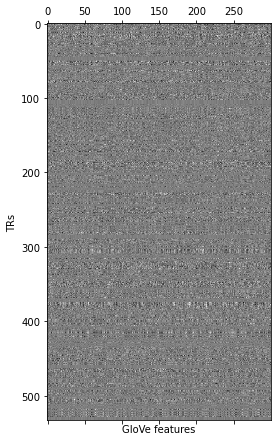

In [28]:
# Visualize predictor matrix of GloVe embeddings:
from scipy.stats import zscore
plt.matshow(zscore(embeddings, axis=0), cmap='binary_r')
plt.xlabel('GloVe features')
plt.ylabel('TRs');

Now, we'll horizontally stack the predictor matrix at lags of 2, 3, 4, and 5 TRs (3, 4.5, 6, 7.5 seconds) to account for variability in hemodynamic lag. Here's one recipe to do this: For each lag, first create prepending zero vectors for each TR in the lag; next, create appending zero vectors corresponding to the difference between the longest lag and the current lag; then, concatenate the prepending and appending vectors at the beginning and end of the predictor matrix, respectively. Horizontally stack the lagged matrices, z-score each column in the lagged predictor matrix, and visualize the matrix.

In [29]:
prepend.shape

NameError: name 'prepend' is not defined

In [ ]:
append.shape

In [ ]:
# Create temporally delayed version of embeddings:
lags = [2, 3, 4, 5]

embeddings_lag = []
for lag in lags:
    prepend = np.zeros((lag, glove_dim))
    append = np.zeros((lags[-1] - lag, glove_dim))
    lagged = np.vstack((prepend, embeddings, append))
    embeddings_lag.append(lagged)

# Horizontally stack lagged embeddings:
embeddings_lag = np.hstack(embeddings_lag)

# Z-score embeddings:
from scipy.stats import zscore
embeddings_lag = zscore(embeddings_lag, axis=0)

# Plot lagged predictor matrix:
plt.matshow(embeddings_lag, cmap='binary_r')
plt.xlabel('GloVe features')
plt.ylabel('TRs');

The fMRI data were collected with an 8-TR buffer prior to the beginning of the story stimulus and a 9-TR buffer after the end of the story stimulus. Trim off the starting buffer TRs, as well as the ending buffer TRs (excluding TRs for the lags). This should finalize our predictor matrix.

In [ ]:
# Trim fMRI data to match embeddings:
start_trs = 8
end_trs = 9 - lags[-1]

assert start_trs + embeddings_lag.shape[0] + end_trs == func_parcels.shape[0]

func_parcels = func_parcels[start_trs:-end_trs]

In [ ]:
name = 'shrek_fmri.npy'
shrek_fmri = np.load(name, allow_pickle = True)

In [15]:
"""
This includes four buffer TRs on the end, with the first 4 TRs trimmed
So TR 1 [not TR 0] in shrek should be 'so let me get this straight...'
"""

shrek_fmri.shape

(90, 400)

### Ridge regression
Next, we use ridge regression to predict the activity at each parcel from the semantic embeddings. Note that the model dimensionality ($300 * 4$ delays $= 1200$ dimensions) is much greater than the number of samples ($<550$ TRs). This means we'll need to impose strong regularization on the model. Use a split-half outer cross-validation scheme where we train the model on half of the story and test the model on the other half. To search for the best-performing regularization parameter, perform 5-fold inner cross-validation within each training set using `RidgeCV`; this will select the best parameter setting from the inner cross-validation fold within the training half to predict the test half.

In [10]:
# Split-half outer cross-validation fold:
from sklearn.model_selection import KFold

outer_cv = KFold(n_splits=2)
inner_cv = KFold(n_splits=5)

# Ridge regression with alpha grid and nested CV:
from sklearn.linear_model import RidgeCV

alphas = [0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
ridge = RidgeCV(alphas=alphas, cv=inner_cv, scoring='r2')

# Loop through outer split-half cross-validation:
func_predicted = []
for train, test in outer_cv.split(func_parcels):
    
    # Fit ridge regression with grid search
    ridge.fit(embeddings_lag[train],
              func_parcels[train])
    
    # Compute predicted response
    predicted = ridge.predict(embeddings_lag[test])
    func_predicted.append(predicted)
    
# Restack first and second half predictions
func_predicted = np.vstack(func_predicted)

### Evaluating model performance
To evaluate the predictions of our model, we use the model weights estimated from the training data to predict the brain activity from semantic embeddings for the test data. We then assess the similarity between the predicted brain activity and the actual brain activity for the test data. Keeping with conventions in the literature, we use Pearson correlation to assess the match between predicted and actual brain activity (although this is not considered a good scoring metric in machine learning and there are many other options; e.g. $R^2$). For each parcel, compute the Pearson correlation between the actual and predicted test time series. Plot the predicted and actual time series for the superior temporal parcel `196` (z-score the actual and predicted time series for plotting).

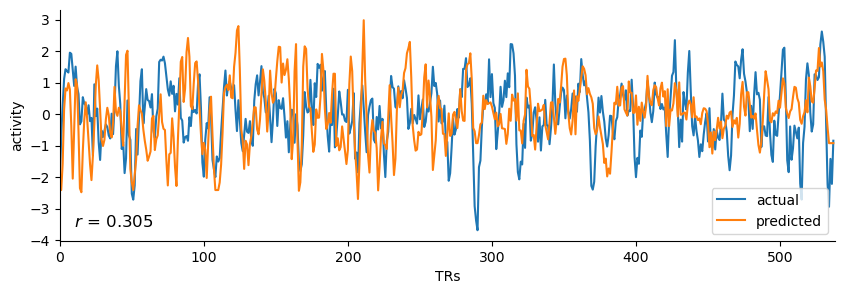

In [11]:
# Compute correlation between predicted and actual responses:
from scipy.stats import pearsonr

r_parcels = []
for parcel in np.arange(func_parcels.shape[1]):
    r_parcels.append(pearsonr(func_parcels[:, parcel],
                              func_predicted[:, parcel])[0])
    
# Plot predicted and actual response for example parcel:
example_parcel = 196
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(zscore(func_parcels[:, example_parcel]), label='actual')
ax.plot(zscore(func_predicted[:, example_parcel]), label='predicted')
ax.annotate(f'$\it{{r}}$ = {r_parcels[example_parcel]:.3f}',
            xy=(10, 10), xycoords='axes points', fontsize=12)
ax.set(xlabel='TRs', ylabel='activity', xlim=(0, func_predicted.shape[0]))
ax.legend()
sns.despine()

Finally, we'll plot the prediction performance scores on the brain. Convert the parcel-level prediction scores back into voxel-level brain maps; that is, for every voxel in a given parcel, assign that voxel the parcel's prediction score. Visualize the resulting brain map using `plot_stat_map`.

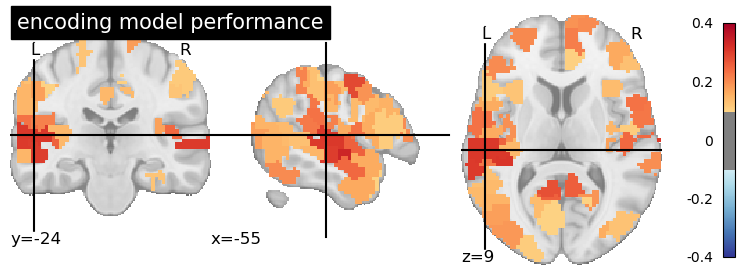

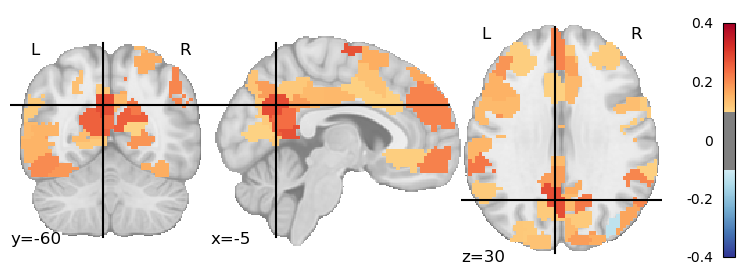

In [12]:
# Plot correlations between actual and predicted responses:
from nilearn.plotting import plot_stat_map

r_img = np.zeros(atlas_img.shape)
for i, parcel in enumerate(np.unique(atlas_img)[1:]):
    r_img[atlas_img == parcel] = r_parcels[i]

# Convert to NIfTI image for visualization with Nilearn
r_nii = nib.Nifti1Image(r_img, atlas_nii.affine, atlas_nii.header)

# Plot correlations to visualize superior temporal cortex
vmax = .4
threshold = .1
plot_stat_map(r_nii, cmap='RdYlBu_r', vmax=vmax, threshold=threshold,
              title='encoding model performance', cut_coords=(-55, -24, 9))

# Plot correlations to visualize posterior medial cortex
plot_stat_map(r_nii, cmap='RdYlBu_r', vmax=vmax, threshold=threshold,
              cut_coords=(-5, -60, 30));

#### References

* Huth, A. G., De Heer, W. A., Griffiths, T. L., Theunissen, F. E., & Gallant, J. L. (2016). Natural speech reveals the semantic maps that tile human cerebral cortex. *Nature*, *532*(7600), 453-458. https://doi.org/10.1038/nature17637

* Nastase, S. A., Liu, Y.-F., Hillman, H., Zadbood, A., Hasenfratz, L., Keshavarzian, N., Chen, J., Honey, C. J., Yeshurun, Y., Regev, M., Nguyen, M., Chang, C. H. C., Baldassano, C., Lositsky, O., Simony, E., Chow, M. A., Leong, Y. C., Brooks, P. P., Micciche, E., Choe, G., Goldstein, A., Vanderwal, T., Halchenko, Y. O., Norman, K. A., & Hasson, U. (2020). Narratives: fMRI data for evaluating models of naturalistic language comprehension. *bioRxiv*. https://doi.org/10.1101/2020.12.23.424091

* Pennington, J., Socher, R., & Manning, C. D. (2014, October). GloVe: Global Vectors for Word Representation. In *Proceedings of the 2014 Conference on Empirical Methods in Natural Language Processing (EMNLP)* (pp. 1532-1543). https://www.aclweb.org/anthology/D14-1162

* Schaefer, A., Kong, R., Gordon, E. M., Laumann, T. O., Zuo, X. N., Holmes, A. J., ... & Yeo, B. T. (2018). Local-global parcellation of the human cerebral cortex from intrinsic functional connectivity MRI. Cerebral cortex, 28(9), 3095-3114. https://doi.org/10.1093/cercor/bhx179